# Transcription Factor Extraction - TF Project Part 1
**Author:** Robin Anwyl

**Objective:** Read in Perturb-Seq hiPSC CRISPR KO scRNA-seq dataset from Mali Lab and extract the transcription factors from the full list of gene knockouts

## Determining which KOs are TF KOs

Extract the set of all gene knockouts from `crispr.var` and save as a .txt file.

In [ ]:
# crispr = mdata["crispr"]
# crispr_sgrnas = crispr.var.index.tolist()
# crispr_genes = {crispr_sgrnas[i][:-2] for i in range(len(crispr_sgrnas))}
# crispr_genes = sorted(list(crispr_genes))
# print(crispr_genes[:10])
# with open("gene_knockouts.txt", "w") as f:
#     for gene in crispr_genes:
#         f.write(gene + "\n")

Read the KO .txt file in.

In [ ]:
# with open("gene_knockouts.txt") as f:
#     gene_kos = f.read().split()
# print(gene_kos[:10])
# print(len(gene_kos))

### Comparing Perturb-seq KOs to human TFs from Lambert et al 2018 study

Lambert et al (2018) identified 1639 human transcription factors; this list of TFs is publicly available as a spreadsheet of each studied gene and whether or not it is a TF. 

Read in the spreadsheet and view the first few rows and columns:

In [ ]:
# lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
# print(lambert_csv.iloc[:10, :4])

Filter TFs from full list

In [ ]:
# lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# print(lambert_tfs[:10])
# print(len(lambert_tfs))

Find the intersection of the set of 11702 Perturb-seq KOs and the set of 1639 transcription factors

In [ ]:
# tfs = set(gene_kos) & set(lambert_tfs)
# tfs = list(tfs)
# tfs.sort()
# print(tfs[:10])
# print(len(tfs))

Some TFs in the Lambert set are missing from the gene KO set. To verify that this is indeed the case, use the Ensembl ID of each missing TF to find alternate gene names (synonyms), and search the gene KO set for these synonyms.

In [ ]:
# # Get missing TFs
# missing_tfs = set(lambert_tfs) - set(tfs)
# print(f"Lambert TFs not present in Perturb-seq KOs: {missing_tfs}")
# # Get Ensembl ID for each missing TF
# missing_tf_ensembl = lambert_csv[lambert_csv.iloc[:, 1].isin(missing_tfs)].iloc[:, 0].tolist()
# print(f"Ensembl IDs for Lambert TFs not in Perturb-seq KOs: {missing_tf_ensembl}")

# # Generate gene synonyms for each missing TF
# def get_ensembl_synonyms(ensembl_id):
#     # Use Ensembl REST API xrefs/id to search up gene synonyms for a given Ensembl ID
#     url = "https://rest.ensembl.org/xrefs/id/" + ensembl_id + "?content-type=application/json"
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         synonyms = list()
#         for xref in data:
#             if xref.get('synonyms'):
#                 synonyms.extend(xref['synonyms'])
#         return synonyms
#     else:
#         return f"Error fetching data for {ensembl_id}: {response.status_code}"
# synonym_list = []
# for id in missing_tf_ensembl:
#     alt_names = list(set(get_ensembl_synonyms(id)))
#     synonym_list.append(alt_names)
# print(f"Gene synonyms for Lambert TFs not in Perturb-seq KOs: {synonym_list}")

# # Search gene KO set for these synonyms
# alt_name_tfs = list()
# for gene_synonyms in synonym_list:
#     for synonym in gene_synonyms:
#         if synonym in gene_kos:
#             alt_name_tfs.append(synonym)
# print(f"TF gene synonyms present in Perturb-seq KOs: {alt_name_tfs}")

None of the synonyms were found in the Perturb-seq gene KO set; thus, the final set of TFs in common between the gene KO set and the Lambert TF set is 1610 TFs. Save the final set of TFs as a .txt file.

In [ ]:
# with open("tfs_1610.txt", "w") as f:
#     for tf in tfs:
#         f.write(tf + "\n")

## Extracting gene KOs from Perturb-Seq dataset
Read in the scRNA-seq dataset, which is a .h5mu file, and assign it to the variable `mdata`

In [ ]:
import mudata
mdata = mudata.read_h5mu("/home/data/Mali_project/KOLF_Pan_Genome_Aggregate.h5mu")

Rich representation of `mdata`, which is a `MuData` object

In [ ]:
with mudata.set_options(display_style = "html", display_html_expand = 0b000):
    display(mdata)

crispr,bool,numpy.ndarray,
rna,bool,numpy.ndarray,


Access the `rna` cell-by-gene matrix and `crispr` cell-by-knockout matrix, which are `AnnData` objects.
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each gene in the human genome
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)

In [ ]:
rna_adata = mdata['rna']
crispr_adata = mdata['crispr']

`rna` and `crispr` both have `obs` and `var` attributes. 

- `obs` = cell barcodes associated with single cells; same for both `rna` and `crispr`  
- `rna.var` = human genes, `crispr.var` = gene knockouts

In [ ]:
rna_adata.var

,gene_ids,feature_types
DDX11L2,ENSG00000290825,Gene Expression
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
ENSG00000290826,ENSG00000290826,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
...,...,...
ENSG00000277836,ENSG00000277836,Gene Expression
ENSG00000278633,ENSG00000278633,Gene Expression
ENSG00000276017,ENSG00000276017,Gene Expression
ENSG00000278817,ENSG00000278817,Gene Expression


In [ ]:
crispr_adata.var

,gene_ids,feature_types
A1BG_1,A1BG_1,CRISPR Guide Capture
A1BG_2,A1BG_2,CRISPR Guide Capture
A1BG_3,A1BG_3,CRISPR Guide Capture
A1CF_1,A1CF_1,CRISPR Guide Capture
A1CF_2,A1CF_2,CRISPR Guide Capture
...,...,...
ZZEF1_2,ZZEF1_2,CRISPR Guide Capture
ZZEF1_3,ZZEF1_3,CRISPR Guide Capture
ZZZ3_1,ZZZ3_1,CRISPR Guide Capture
ZZZ3_2,ZZZ3_2,CRISPR Guide Capture


Get the list of all gene KOs (which can then be compared to a list of human TFs and narrowed down to only the TF KOs)

In [ ]:
crispr_sgrnas = crispr_adata.var.index.tolist()
crispr_genes = {crispr_sgrnas[i][:-2] for i in range(len(crispr_sgrnas))}
crispr_genes = sorted(list(crispr_genes))
print(crispr_genes[:10])
# with open("gene_knockouts.txt", "w") as f:
#     for gene in crispr_genes:
#         f.write(gene + "\n")

['A1BG', 'A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAMP', 'AAR2', 'AARD']


## Extracting list of human TFs from Lambert et al 2018 study

A 2018 study by Lambert et al identified 1639 human transcription factors; this list of TFs is publicly available as a spreadsheet. The spreadsheet includes each studied gene and whether or not it is a TF.

Read in spreadsheet

In [ ]:
import pandas as pd

lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
print(lambert_csv.iloc[:10, :4])

  Gene Information Unnamed: 1   Unnamed: 2 Is TF?
0               ID       Name          DBD    NaN
1  ENSG00000137203     TFAP2A         AP-2    Yes
2  ENSG00000008196     TFAP2B         AP-2    Yes
3  ENSG00000087510     TFAP2C         AP-2    Yes
4  ENSG00000008197     TFAP2D         AP-2    Yes
5  ENSG00000116819     TFAP2E         AP-2    Yes
6  ENSG00000117713     ARID1A  ARID/BRIGHT     No
7  ENSG00000049618     ARID1B  ARID/BRIGHT     No
8  ENSG00000116017     ARID3A  ARID/BRIGHT    Yes
9  ENSG00000179361     ARID3B  ARID/BRIGHT    Yes


Filter TFs from full list

In [ ]:
lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
print(lambert_tfs[:10])
print(len(lambert_tfs))

['TFAP2A', 'TFAP2B', 'TFAP2C', 'TFAP2D', 'TFAP2E', 'ARID3A', 'ARID3B', 'ARID3C', 'ARID5A', 'ARID5B']
1639


Sanity check: TF count is correct

## Comparing gene KOs to Lambert TFs

Read in gene KO file

In [ ]:
with open("gene_knockouts.txt") as f:
    gene_kos = f.read().split()
print(gene_kos)
print(len(gene_kos))

['A1BG', 'A1CF', 'A4GALT', 'AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAMP', 'AAR2', 'AARD', 'AARS1', 'AARS2', 'AASDH', 'AASDHPPT', 'AASS', 'AATF', 'ABAT', 'ABCA2', 'ABCA3', 'ABCA7', 'ABCB10', 'ABCB6', 'ABCB7', 'ABCB8', 'ABCC1', 'ABCC10', 'ABCC5', 'ABCD1', 'ABCD3', 'ABCD4', 'ABCE1', 'ABCF1', 'ABCF2', 'ABCF3', 'ABCG1', 'ABCG4', 'ABHD10', 'ABHD11', 'ABHD12', 'ABHD13', 'ABHD14B', 'ABHD15', 'ABHD16B', 'ABHD17A', 'ABHD17B', 'ABHD17C', 'ABHD2', 'ABHD4', 'ABHD5', 'ABHD8', 'ABI1', 'ABI2', 'ABI3', 'ABITRAM', 'ABL1', 'ABL2', 'ABLIM1', 'ABRA', 'ABRACL', 'ABRAXAS1', 'ABRAXAS2', 'ABT1', 'ABTB1', 'ACAA1', 'ACAA2', 'ACACA', 'ACACB', 'ACAD10', 'ACAD8', 'ACAD9', 'ACADM', 'ACADS', 'ACADSB', 'ACADVL', 'ACAP1', 'ACAP2', 'ACAP3', 'ACAT1', 'ACAT2', 'ACBD3', 'ACBD4', 'ACBD5', 'ACBD6', 'ACBD7', 'ACCS', 'ACD', 'ACE', 'ACER2', 'ACER3', 'ACHE', 'ACIN1', 'ACKR1', 'ACLY', 'ACO1', 'ACO2', 'ACOT1', 'ACOT13', 'ACOT2', 'ACOT4', 'ACOT7', 'ACOT8', 'ACOT9', 'ACOX1', 'ACP1', 'ACP2', 'ACP5', 'ACP6', 'ACSBG1', 'ACSBG2', 'ACSF2', 'A

Find the intersection of the set of 11702 gene knockouts and the set of 1639 transcription factors

In [ ]:
tfs = set(gene_kos) & set(lambert_tfs)
tfs = list(tfs)
tfs.sort()
print(tfs[:10])
print(len(tfs))

['ADNP', 'ADNP2', 'AEBP1', 'AEBP2', 'AHCTF1', 'AHDC1', 'AHR', 'AHRR', 'AIRE', 'AKAP8']
1610


### Verifying difference between Lambert set (1639 TFs) and Perturb-seq TF set (1610 TFs)

There are some TFs in the Lambert set that are missing from the gene KO set. To verify that this is the case, use the Ensembl ID of each missing TF to find alternate gene names (synonyms), and search the gene KO set for these synonyms.

In [ ]:
missing_tfs = set(lambert_tfs) - set(tfs)
print(missing_tfs)
missing_tf_ensembl = lambert_csv[lambert_csv.iloc[:, 1].isin(missing_tfs)].iloc[:, 0].tolist()
print(missing_tf_ensembl)

{'AC023509.3', 'ZNF705G', 'ZNF645', 'ZNF547', 'ARNTL', 'ZNF117', 'CENPBD1', 'ZNF788', 'DUX3', 'HKR1', 'CCDC169-SOHLH2', 'EEA1', 'DUX1', 'C11orf95', 'ZIM2', 'ARNTL2', 'ZNF705E', 'T', 'ZNF385D', 'ZBED9', 'AC008770.3', 'ZUFSP', 'PHF19 ', 'AC138696.1', 'ZNF286B', 'MSANTD1', 'MBNL2', 'BORCS8-MEF2B', 'AC092835.1'}
['ENSG00000188070', 'ENSG00000232040', 'ENSG00000133794', 'ENSG00000029153', 'ENSG00000250709', 'ENSG00000267281', 'ENSG00000267179', 'ENSG00000233757', 'ENSG00000264668', 'ENSG00000102189', 'ENSG00000181666', 'ENSG00000269699', 'ENSG00000152926', 'ENSG00000249459', 'ENSG00000151789', 'ENSG00000152433', 'ENSG00000175809', 'ENSG00000214534', 'ENSG00000215372', 'ENSG00000214189', 'ENSG00000153975', 'ENSG00000139793', 'ENSG00000177946', 'DUX1_HUMAN', 'DUX3_HUMAN', 'ENSG00000188981', 'ENSG00000064489', 'ENSG00000119403', 'ENSG00000164458']


Using the Ensembl REST API, GET lookup/id did not return any synonyms, so try GET xrefs/id to cross-reference other databases.

In [ ]:
import requests

def get_ensembl_synonyms(ensembl_id):
    # Use Ensembl REST API xrefs/id to search up gene synonyms for a given Ensembl ID
    url = "https://rest.ensembl.org/xrefs/id/" + ensembl_id + "?content-type=application/json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        synonyms = list()
        for xref in data:
            if xref.get('synonyms'):
                synonyms.extend(xref['synonyms'])
        return synonyms
    else:
        return f"Error fetching data for {ensembl_id}: {response.status_code}"

# Store gene synonyms as a nested list
synonym_list = []
for id in missing_tf_ensembl:
    alt_names = list(set(get_ensembl_synonyms(id)))
    synonym_list.append(alt_names)
print(synonym_list)

[['MGC3032', 'C11ORF95'], ['FLJ31087', 'KIAA1925', 'BUSTER4', 'ZFP38-L', 'ZNF305P2', 'ZNF452', 'ZBED9', 'FAM200D'], ['ARNTL1', 'JAP3', 'BHLHE5', 'ARNTL', 'MOP3', 'PASD3'], ['BHLHE6', 'MOP9', 'ARNTL2', 'PASD9', 'CLIF'], ['C13ORF38-SOHLH2'], [], [], [], [], ['ZFYVE2'], ['HKR1'], ['ZNF656'], ['H-PLK', 'HPF9'], ['ZNF286C', 'ZNF590', 'ZNF286L'], ['FLJ22419', 'ZNF659'], ['FLJ31100'], ['HAKAIL', 'ZNF645', 'FLJ25735', 'CT138'], ['ZNF705E'], [], ['ZNF788', 'FLJ46419'], ['C6ORF113', 'ZUFSP', 'DJ412I7.3'], ['MBLL', 'MBLL39'], ['CENPBD1', 'MGC16385'], ['M', '0', 'e', 'X', 'h', 'c', 'A', 'N', 'g', '4', 'n', 'i', 't', ':', 'H', '1', 'E', 'D', 'd', 'f', '_', ' ', 'a', 'r', 'U', 'o'], ['M', '0', 'e', 'X', 'h', 'c', 'A', 'N', 'g', '4', 'n', 'i', 't', ':', 'H', 'E', 'D', 'd', '3', 'f', '_', ' ', 'a', 'r', 'U', 'o'], ['C4ORF44', 'LOC345222'], ['MEF2BNB-MEF2B'], ['MTF2L1', 'TDRD19B', 'DKFZP727G051', 'PCL3'], ['T']]


Synonyms were found for all genes except DUX1 and DUX3. A manual Google search was performed for DUX1 and DUX3 and found no synonyms. Next, search the gene KO list for these gene synonyms.

In [ ]:
alt_name_tfs = list()
for gene_synonyms in synonym_list:
    for synonym in gene_synonyms:
        if synonym in gene_kos:
            alt_name_tfs.append(synonym)
print(alt_name_tfs)

[]


None of the synonyms were found in the Perturb-seq gene KO set; thus, the final set of TFs in common between the gene KO set and the Lambert TF set is 1610 TFs.

### Saving the TF list

Save the list of 1610 TFs in the gene KO set as a .txt file

In [ ]:
# with open("tfs_1610.txt", "w") as f:
#     for tf in tfs:
#         f.write(tf + "\n")

***
# Transcription Factor Analysis - TF Project Part 2

**Author:** Robin Anwyl

**Objective:** 1610 transcription factors were identified from the set of Perturb-Seq gene knockouts. The next broad goal of the project is to build a transcription factor interaction network. The methodology for building the TF interaction network will depend on what information is specifically included in the Perturb-seq dataset. In this notebook, we will take a closer look at the dataset.

Import packages

In [ ]:
import mudata as md
import anndata as ad
import rapids_singlecell as rsc
import scanpy as sc
import pandas as pd
import numpy as np
import re

Read in Perturb-seq dataset and add sgRNA metadata to cell barcodes

In [ ]:
mdata = md.read_h5mu("/home/data/Mali_project/KOLF_Pan_Genome_Aggregate.h5mu")

/home/ranwyl/.conda/envs/rsc_env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/ranwyl/.conda/envs/rsc_env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [ ]:
rna = mdata['rna']
print(rna)

AnnData object with n_obs × n_vars = 5386783 × 38606
    var: 'gene_ids', 'feature_types'


In [ ]:
protospacer_calls = pd.read_csv("/home/data/Mali_project/protospacer_calls_per_cell.csv", index_col=0)

,num_features,feature_call,num_umis
cell_barcode,,,
TGCGACGTCAACTCTT-24,1,ADNP2-1,20
AACGTCACATAATCCG-25,2,ADNP2-1|MACROH2A2-1,11|11
ACGCACGAGCCTATTG-25,2,ADNP2-1|Non-Targeting-498,21|22
AGAGCCCCACGCTGCA-25,1,ADNP2-1,44
AGGGTTTGTTACCCAA-25,2,ADNP2-1|ZNF33A-3,7|19


In [ ]:
print(rna.obs.index[:5])
print(print(protospacer_calls.index[:5]))
print(len(rna.obs))
print(len(protospacer_calls))

Index(['AAACCCAAGAAACCCG-34', 'AAACCCAAGAAACCCG-75', 'AAACCCAAGAAACTAC-10',
       'AAACCCAAGAAACTCA-14', 'AAACCCAAGAAACTCA-2'],
      dtype='object')
Index(['CAGAGCCTCCGGACGT-31', 'CATTGCCTCTTGGGCG-31', 'TGATCTTTCAATGTCG-31',
       'TTGTGGAAGGTTGGAC-31', 'ACATGCACACATACGT-32'],
      dtype='object', name='cell_barcode')
None
5386783
4369394


In [ ]:
rna_barcodes = rna.obs.index
protospacer_barcodes = protospacer_calls.index
# Filter RNA to include only barcodes present in the protospacer file
filtered_barcodes = rna_barcodes[rna_barcodes.isin(rna_barcodes, protospacer_barcodes)]
rna_filtered = rna[filtered_barcodes, :]
# Sort both the RNA and protospacer datasets by barcode
rna_filtered_sorted = rna_filtered[filtered_barcodes.sort()]
protospacer_calls_sorted = protospacer_calls.loc[filtered_barcodes.sort()]
# Align protospacer metadata (sgRNAs) to rna.obs
rna_filtered_sorted.obs['sgRNA'] = protospacer_calls_sorted['feature_call']

Read in TFs

In [ ]:
with open("tfs_1610.txt") as f:
    tfs = f.read().split()
print(tfs[:100])
print(len(tfs))

['ADNP', 'ADNP2', 'AEBP1', 'AEBP2', 'AHCTF1', 'AHDC1', 'AHR', 'AHRR', 'AIRE', 'AKAP8', 'AKAP8L', 'AKNA', 'ALX1', 'ALX3', 'ALX4', 'ANHX', 'ANKZF1', 'AR', 'ARGFX', 'ARHGAP35', 'ARID2', 'ARID3A', 'ARID3B', 'ARID3C', 'ARID5A', 'ARID5B', 'ARNT', 'ARNT2', 'ARX', 'ASCL1', 'ASCL2', 'ASCL3', 'ASCL4', 'ASCL5', 'ASH1L', 'ATF1', 'ATF2', 'ATF3', 'ATF4', 'ATF5', 'ATF6', 'ATF6B', 'ATF7', 'ATMIN', 'ATOH1', 'ATOH7', 'ATOH8', 'BACH1', 'BACH2', 'BARHL1', 'BARHL2', 'BARX1', 'BARX2', 'BATF', 'BATF2', 'BATF3', 'BAZ2A', 'BAZ2B', 'BBX', 'BCL11A', 'BCL11B', 'BCL6', 'BCL6B', 'BHLHA15', 'BHLHA9', 'BHLHE22', 'BHLHE23', 'BHLHE40', 'BHLHE41', 'BNC1', 'BNC2', 'BPTF', 'BRF2', 'BSX', 'CAMTA1', 'CAMTA2', 'CARF', 'CASZ1', 'CBX2', 'CC2D1A', 'CCDC17', 'CDC5L', 'CDX1', 'CDX2', 'CDX4', 'CEBPA', 'CEBPB', 'CEBPD', 'CEBPE', 'CEBPG', 'CEBPZ', 'CENPA', 'CENPB', 'CENPS', 'CENPT', 'CENPX', 'CGGBP1', 'CHAMP1', 'CHCHD3', 'CIC']
1610


## Subsetting single-TF KO and non-targeting control samples

For this project, we only want to consider single-TF knockout and non-targeting control (NTC) samples. The CRISPR perturbation metadata file "protospacer_calls_per_cell.csv" contains information on which CRISPR guide RNA(s) each cell received. First, we will read in and view the file.

Next, we will use the sgRNA-per-cell information and the list of 1610 TFs to generate a subset of cell barcodes corresponding to single-TF KO and NTC cell samples only.

In [ ]:

tfs = set(tfs)
# Filter function
def is_single_tf_or_ntc(feature_call):
    # Return True if feature_call is a single TF KO or single non-targeting gRNA
    if "|" not in feature_call:
        if re.match(r"Non-Targeting-\d+", feature_call) or feature_call[:-2] in tfs:
            return True
    # Return True if feature_call is a single TF KO and one or more non-targeting gRNAs
    guide_rnas = set(feature_call.split("|"))
    tf_kos, nt_rnas = set(), set()
    for g in guide_rnas:
        if re.match(r"Non-Targeting-\d+", g):
            nt_rnas.add(g)
        elif g[:-2] in tfs:
            tf_kos.add(g)
    if (guide_rnas - tf_kos - nt_rnas): # Return False if any gRNAs are not TFs or NTs
        return False
    if len(tf_kos) == 1:
        return True
    else:
        return False
# Test the filter function on a representative subset of file
test_df = protospacer_df[108885:110000]
filter_test = test_df[test_df["feature_call"].apply(is_single_tf_or_ntc)]
display(filter_test)

,cell_barcode,num_features,feature_call,num_umis
108885,TGCGACGTCAACTCTT-24,1,ADNP2-1,20
108887,ACGCACGAGCCTATTG-25,2,ADNP2-1|Non-Targeting-498,21|22
108888,AGAGCCCCACGCTGCA-25,1,ADNP2-1,44
108891,ATTACTCGTCCACGCA-25,1,ADNP2-1,9
108894,CACTGAATCAAAGAAC-25,1,ADNP2-1,24
...,...,...,...,...
109976,TGAGGGAAGCGCCTCA-28,1,ADNP2-3,40
109979,TTCTAGTGTCACTTCC-28,1,ADNP2-3,49
109989,GACTTCCAGCACTCTA-29,2,ADNP2-3|Non-Targeting-923,4|5
109992,GGATGTTTCTTACGTT-29,1,ADNP2-3,77


Save the list of cell barcodes in "filtered_barcodes.txt"

In [ ]:
# Run filter function and save list of cell barcodes as .txt file
# filtered_df = protospacer_df[protospacer_df["feature_call"].apply(is_single_tf_or_ntc)]
# filtered_barcodes = filtered_df["cell_barcode"]
# with open("filtered_barcodes.txt", "w") as f:
#     for barcode in filtered_barcodes:
#         f.write(f"{barcode}\n")

Read in "filtered_barcodes.txt" to get the list of cell barcodes corresponding to single-TF KO or NTC samples.

In [ ]:
with open("filtered_barcodes.txt") as f:
    barcodes = f.read().split()
print(barcodes[:10])
print(len(barcodes))

['CATTGTTCACAGTGAG-1', 'CCCTCTCAGGTTCATC-1', 'CCTTTGGGTAACCCTA-2', 'CGCCATTGTTCGTTCC-2', 'GATGCTACATCGCCTT-2', 'GGTGTTAAGGTCGTGA-3', 'TGAATCGAGTATCTGC-3', 'GAGGGTATCCGCTGTT-4', 'GCTCAAATCGAGCACC-7', 'GGGCGTTTCGATTTCT-7']
628136


Out of the 5,386,783 cells in the dataset, 628,136 correspond to single-TF knockouts or NTC samples.

We also want to differentiate between NTC and single-TF KO samples. First, we will write a filter function for NTC samples.

In [ ]:
tfs = set(tfs)
# Filter function for NTC samples
def is_ntc(feature_call):
    # Return True if feature_call is a single non-targeting gRNA
    if "|" not in feature_call:
        if re.match(r"Non-Targeting-\d+", feature_call):
            return True
    # Return True if feature_call is multiple non-targeting gRNAs
    guide_rnas = set(feature_call.split("|"))
    nt_rnas = set()
    for g in guide_rnas:
        if re.match(r"Non-Targeting-\d+", g):
            nt_rnas.add(g)
    if len(guide_rnas) == len(nt_rnas): # Return True if all gRNAs are non-targeting
        return True
    else:
        return False
# Test NTC filter function on a representative subset of file
test_df = protospacer_df[2768320:2768328]
filter_test = test_df[test_df["feature_call"].apply(is_ntc)]
display(filter_test)

,cell_barcode,num_features,feature_call,num_umis
2768323,TGAGCATTCCATTCAT-1,1,Non-Targeting-1,84
2768324,AAACGCTAGGTGCTGA-2,1,Non-Targeting-1,30
2768325,AGTAACCCACCGAATT-2,1,Non-Targeting-1,9
2768326,CAACAGTGTCCGAAAG-2,1,Non-Targeting-1,5


Save the NTC cell barcodes in a .txt file.

In [ ]:
# Run TF KO filter function and save list of cell barcodes as .txt file
# filtered_df = protospacer_df[protospacer_df["feature_call"].apply(is_single_tf)]
# filtered_barcodes = filtered_df["cell_barcode"]
# with open("filtered_barcodes.txt", "w") as f:
#     for barcode in filtered_barcodes:
#         f.write(f"{barcode}\n")

## Cell-By-TF UMAP

### Setup and Preprocessing

In this section, we will narrow down the cell-by-gene matrix to a cell-by-TF matrix and perform UMAP analysis. First, we will create a new AnnData object for the cell-by-TF matrix.

In [ ]:
rna = mdata['rna']
# Filter cells (single-TF KOs or NTC samples)
filtered_cells = rna.obs.index.isin(barcodes)
rna_filtered = rna[filtered_cells, :]
# Filter genes (TFs)
filtered_genes = rna_filtered.var.index.isin(tfs)
rna_cell_by_tf = rna_filtered[:, filtered_genes]
# Create a new AnnData object for filtered dataset
rna_cell_by_tf = ad.AnnData(rna_cell_by_tf.X, obs=rna_cell_by_tf.obs.copy(), var=rna_cell_by_tf.var.copy())

Save this AnnData object as a .h5ad file.

In [ ]:
#rna_cell_by_tf.write("/home/data/Mali_project/cell_by_tf.h5ad")

Read in cell-by-TF .h5ad file.

In [ ]:
cell_by_tf = ad.read_h5ad("/home/data/Mali_project/cell_by_tf.h5ad")

Transfer AnnData object to GPU.

In [ ]:
rsc.get.anndata_to_GPU(cell_by_tf)

Perform QC and preprocessing.

In [ ]:
rsc.pp.calculate_qc_metrics(cell_by_tf)

Generate violin plots.

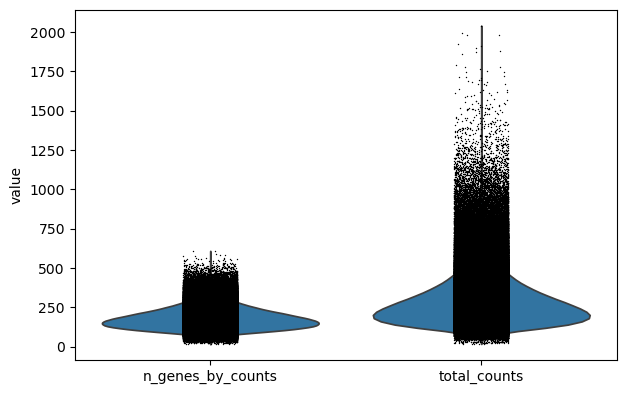

In [ ]:
sc.pl.violin(cell_by_tf, ["n_genes_by_counts", "total_counts"])

In [ ]:
print(f"shape before removing genes with zero expression: {cell_by_tf.shape}")
cell_by_tf = cell_by_tf[:, cell_by_tf.X.sum(axis=0) > 0]
cell_by_tf = cell_by_tf.copy()
print(f"shape after: {cell_by_tf.shape}")

shape before removing genes with zero expression: (628136, 1610)
shape after: (628136, 1590)


Of the 1610 TFs that were knocked out in the dataset, only 1590 are expressed in the single-TF-KO and NTC subset.

## PCA, Neighbors, and UMAP

Now we will perform PCA to reduce dimensionality of the data.

In [ ]:
rsc.pp.pca(cell_by_tf)

W will generate an elbow plot to inspect the contribution of single principal components (PCs) to the total variance in the data. This gives us information on how many PCs to consider in future analysis.

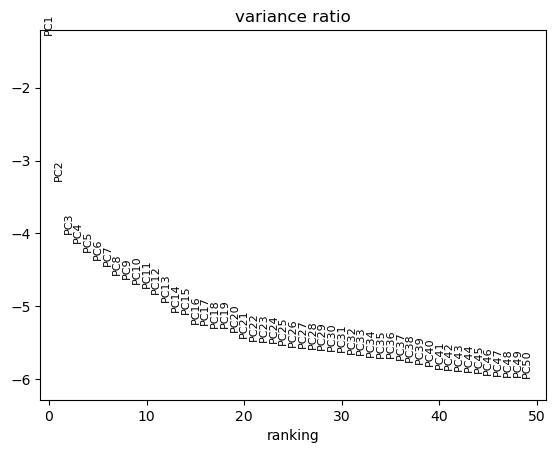

In [ ]:
sc.pl.pca_variance_ratio(cell_by_tf, n_pcs=50, log=True)

We will also visualize the first 10 PCs.

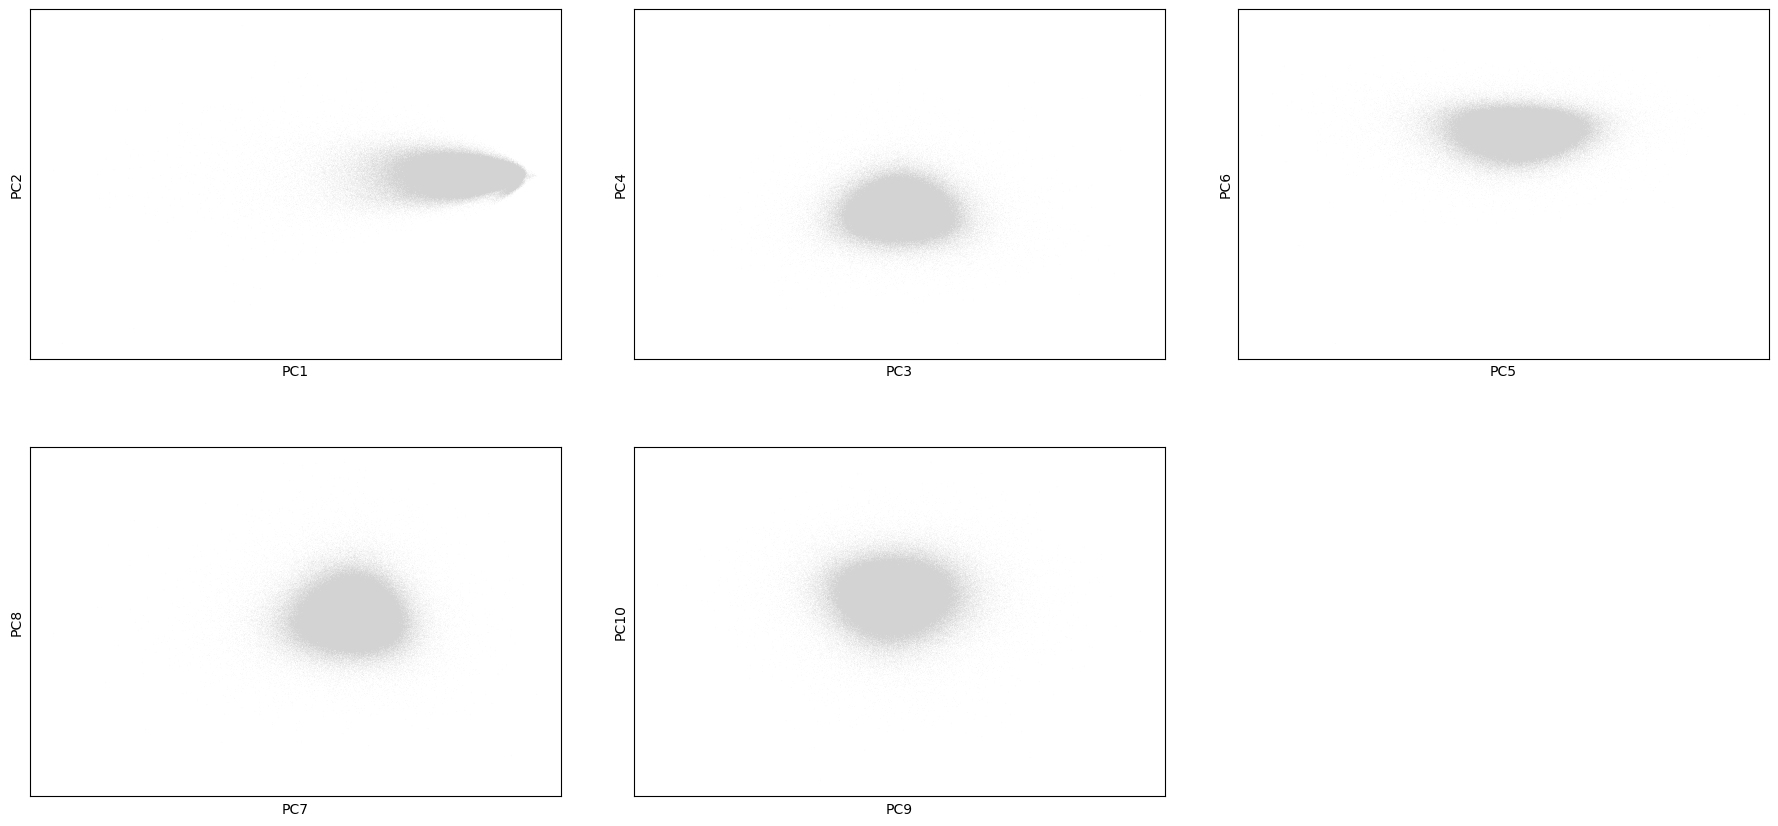

In [ ]:
sc.pl.pca(cell_by_tf, dimensions=[(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)], ncols = 3)

Now that we have performed PCA, we will compute the neighborhood graph of the cell-by-TF matrix.

In [ ]:
rsc.pp.neighbors(cell_by_tf)

Next, we will embed the neighborhood graph for UMAP visualization. Based on the PCA elbow plot, we will use 20 principal components for UMAP.

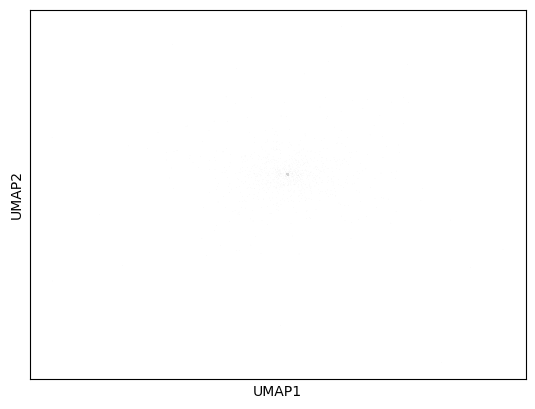

In [ ]:
rsc.tl.umap(cell_by_tf, n_components=20)
sc.pl.umap(cell_by_tf)

We will try UMAP embedding and visualization again without specifying n_components.

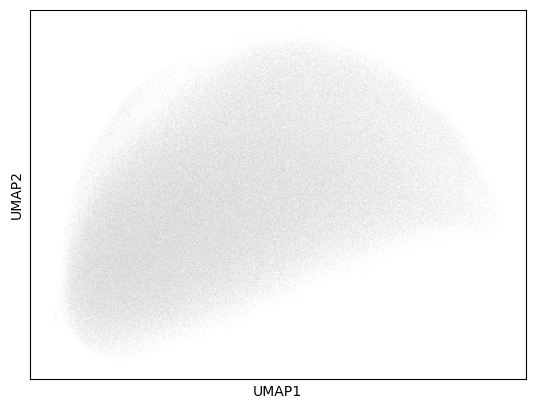

In [ ]:
rsc.tl.umap(cell_by_tf)
sc.pl.umap(cell_by_tf)

Perform Leiden clustering on the full UMAP.

In [ ]:
rsc.tl.leiden(cell_by_tf)

Visualize the UMAP after clustering.

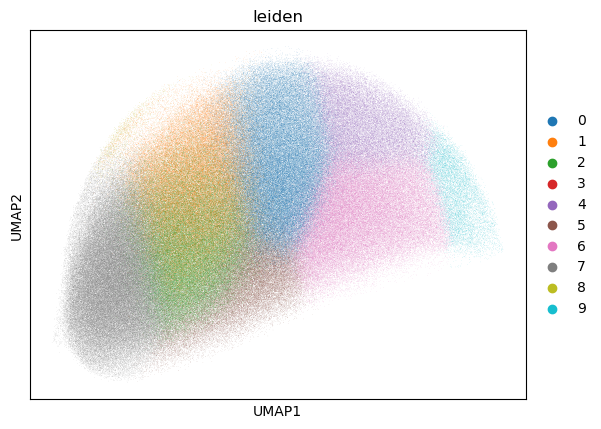

In [ ]:
sc.pl.umap(cell_by_tf, color=["leiden"])

We will now obtain the cluster-specific differentially expressed genes (DEGs). We will display 20 genes per cluster.

In [ ]:
rsc.tl.rank_genes_groups_logreg(cell_by_tf, groupby="leiden", n_genes=20)

[W] [16:52:52.156537] L-BFGS: max iterations reached
[W] [16:52:52.158238] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


## TF KO Differentially Expressed Genes

In this section, we will perform differential expression analysis to find the differentially expressed genes (DEGs) for each TF KO.

***
# QC tests

Note: A list of cell barcodes and genes that passed QC through step D was provided. However, the following discrepancies were noticed:
-  The number of genes in the list (38606) was equal to the number of genes in the original dataset, but greater than the actual number of genes that passed QC step C in Pan_Genome_Analysis.ipynb (37567)
-  The list of cells should only include perturbed cells and core NTC cells. The number of NTC cells in the list (38490) is greater than the number of core NTC cells in Pan_Genome_Analysis.ipynb (37433).

### Testing pipeline step G

In [ ]:
# This is the code that caused the trouble!
# adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
# adata_alpha.X = adata_alpha.layers["counts"].copy()
# results_dict_alpha = qc2.run_deseq2_analysis(adata_alpha)
# deg_results_df_alpha = qc2.save_DEG_df(results_dict_alpha,filepath="/home/ranwyl/results_tf_project/ALPHA_DEGs.xlsx");
# qc2.plot_differentially_expressed_genes(results_dict_alpha)

3/12:
-  Started with 12GB RAM used
-  Then read in `adata_alpha`, usage = 28GB (so `adata_alpha` uses 16GB RAM)
-  Changed `adata.alpha.X` to the raw counts, usage = 18GB (so `adata_alpha` now uses 6GB RAM)
-  Took 27 seconds to run differential expression analysis on 2 gene targets out of 1466, now usage = 36GB. 24GB is used by me, 6GB for `adata_alpha` and 9GB for DEA results for each gene target

3/13
-  Started with 110GB RAM used
-  Read in `adata_alpha` and changed X to raw counts, usage = 116GB
-  Ran DEA on 4 gene targets which took 50 seconds, usage = 133GB, 17GB/4 = 4.25GB per gene target
-  Restarted kernel and then ran DEA on 10 gene targets which took 2 minutes, usage = 133GB = 17GB/10 = 1.7GB per gene target
-  Restarted kernel and then ran DEA on 50 gene targets which took 9min 39s, usage = 135GB-116GB = 18GB/50 = 0.36GB per gene target

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

Determine how many gene targets are in each ALPHA, BETA, GAMMA batch
-  ALPHA: 1466 gene targets
-  BETA: 1695 gene targets
-  GAMMA: 1069 gene targets

In [ ]:
# adata_beta = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_BETA_Core_Cells.h5ad")
# adata_gamma = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_GAMMA_Core_Cells.h5ad")

In [ ]:
def get_gene_targets(adata):
    gene_targets = list(adata.obs["gene_target"].unique())
    gene_targets.remove("NTC")  # Remove the control group
    return gene_targets
gene_targets_alpha = get_gene_targets(adata_alpha)
gene_targets_beta = get_gene_targets(adata_beta)
gene_targets_gamma = get_gene_targets(adata_gamma)
print(f"ALPHA: {len(gene_targets_alpha)} gene targets")
print(f"first 10 gene targets in ALPHA: {gene_targets_alpha[:10]}")
print(f"first 10 gene targets in ALPHA, sorted: {sorted(gene_targets_alpha)[:10]}")
print(f"BETA: {len(gene_targets_beta)} gene targets")
print(f"first 10 gene targets in BETA: {gene_targets_beta[:10]}")
print(f"first 10 gene targets in BETA, sorted: {sorted(gene_targets_beta)[:10]}")
print(f"GAMMA: {len(gene_targets_gamma)} gene targets")
print(f"first 10 gene targets in GAMMA: {gene_targets_gamma[:10]}")
print(f"first 10 gene targets in GAMMA, sorted: {sorted(gene_targets_gamma)[:10]}")

ALPHA: 1466 gene targets
first 10 gene targets in ALPHA: ['DMRT2', 'CREBBP', 'SIRT1', 'OSR2', 'RAD51B', 'AARS2', 'CELF2', 'SUPV3L1', 'H3C12', 'BHLHA9']
first 10 gene targets in ALPHA, sorted: ['AACS', 'AARS2', 'AASDH', 'AATF', 'ABCF1', 'ABRAXAS1', 'ACAD8', 'ACSBG1', 'ACSBG2', 'ACSF2']
BETA: 1695 gene targets
first 10 gene targets in BETA: ['ACTN1', 'TWSG1', 'IFFO1', 'FDXACB1', 'LYPLA2', 'ZFAND1', 'ATP1A3', 'JOSD1', 'CHP2', 'TMUB1']
first 10 gene targets in BETA, sorted: ['AAAS', 'AAR2', 'AARD', 'AASS', 'ABCA2', 'ABCD4', 'ABHD13', 'ABHD17A', 'ABHD17C', 'ABHD4']
GAMMA: 1069 gene targets
first 10 gene targets in GAMMA: ['STIMATE', 'ESRP2', 'BECN1', 'FZD3', 'MPND', 'GLA', 'EEIG2', 'HMCN2', 'GLCCI1', 'LYN']
first 10 gene targets in GAMMA, sorted: ['ABCB10', 'ABCC5', 'ABCG1', 'ABHD11', 'ABHD12', 'ABI1', 'ABRACL', 'ACBD4', 'ACCS', 'ACER2']


Write function `test_run_deseq2_analysis()` that runs the same code as `run_deseq2_analysis()` on a smaller subset of genes

In [ ]:
def test_run_deseq2_analysis(adata, n_gene_targets, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata_alpha.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata_alpha.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
            pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
                adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
            )
            return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)
    
    results = list()
    for gene_target in gene_targets[:n_gene_targets]:
          results.append(process_gene_target(gene_target))
    results_dict = dict(zip(gene_targets, results))
    return results_dict

Run `test_run_deseq2_analysis()` on 16 gene targets with no parallelization. Used 18GB RAM.

In [ ]:
alpha16 = test_run_deseq2_analysis(adata_alpha, 16)

Write slightly modified version of `run_deseq2_analysis()` where `n_jobs` (number of jobs to run in parallel using multiple CPUs) is not set to all available CPUs by default

In [ ]:
def test_run_deseq2_analysis_parallel(adata, n_gene_targets, n_jobs, gene_target_obs_column="gene_target", ntc_cells_delimiter="NTC", n_replicates=3, sample_fraction=0.7, layer=None, alpha=0.05):
    ntc_cells = np.where(adata.obs[gene_target_obs_column] == ntc_cells_delimiter)[0]
    gene_targets = list(adata.obs[gene_target_obs_column].unique())
    gene_targets.remove(ntc_cells_delimiter)  # Remove the control group

    def process_gene_target(gene_target):
        pseudo_bulk_df, metadata_df = qc2.generate_pseudo_bulk_replicates_for_de(
            adata, gene_target, ntc_cells, n_replicates=n_replicates, sample_fraction=sample_fraction, layer=layer
        )
        return qc2.deseq2(pseudo_bulk_df, metadata_df, contrast=["condition", gene_target, ntc_cells_delimiter], alpha=alpha)

    gene_targets = gene_targets[:n_gene_targets] # Subset gene targets for testing
    print(f"Number of gene targets: {len(gene_targets)}")
    with tqdm_joblib(desc="Running DE analysis", total=len(gene_targets)):
        results = Parallel(n_jobs=n_jobs)(delayed(process_gene_target)(gene_target) for gene_target in gene_targets)
    
    results_dict = dict(zip(gene_targets, results))
    
    return results_dict

Read in data

In [ ]:
adata_alpha = ad.read_h5ad("/home/ranwyl/data_tf_project/Aggregate_ALPHA_Core_Cells.h5ad")
adata_alpha.X = adata_alpha.layers["counts"].copy()

**Test parallel processing where number of gene targets = number of CPUs**

Run `test_run_deseq2_analysis_parallel()` with 2 gene targets and 2 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 160GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 2, 2)

Number of gene targets: 2


Running DE analysis:   0%|          | 0/2 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 4 gene targets and 4 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  While running: usage = 196GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 4)

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

Run `test_run_deseq2_analysis_parallel()` with 8 gene targets and 8 CPUs
-  Before starting kernel: usage = 113GB RAM
-  After data, before running alpha16_parallel: usage = 119GB
-  First jumps up to 126GB, then all the way to 267GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 8)

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Run `test_run_deseq2_analysis_parallel()` with 16 gene targets and 16 CPUs
-  Before: 119GB
-  Immediate increase: 119GB -> 128GB
-  Max usage: 409GB

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 16)

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

**Test parallel processing where number of gene targets = 2 * number of CPUs**

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 4, 2) # 119 -> 126 -> 160GB

Number of gene targets: 4


Running DE analysis:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 8, 4) # 119 -> 126 -> 196

Number of gene targets: 8


Running DE analysis:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 16, 8) # 120 -> 129 -> 267GB

Number of gene targets: 16


Running DE analysis:   0%|          | 0/16 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 32, 16) # 119 -> 133 -> 408 -> 403

Number of gene targets: 32


Running DE analysis:   0%|          | 0/32 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


In [ ]:
results = test_run_deseq2_analysis_parallel(adata_alpha, 64, 16) # 119 -> 131 -> 408

Number of gene targets: 64


Running DE analysis:   0%|          | 0/64 [00:00<?, ?it/s]

/home/ranwyl/venv311/lib64/python3.11/site-packages/pydeseq2/dds.py:804: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.


Write modified function to save DEG DataFrame as .xlsx file

In [ ]:
def save_DEG_df(results_dict, p_threshold=0.05, save=True, filepath=None):
    # Initialize a dictionary to store columns for the final DataFrame
    final_dict = {}

    for gene_target, df in results_dict.items():
        # Filter the DataFrame based on the padj (adjusted p-value) threshold
        filtered_df = df[df['padj'] < p_threshold]

        # Sort by L2FC
        l2fc_sorted = filtered_df.sort_values('log2FoldChange')
        
        # Create columns for DEGs, L2FC, and Adj_P and add them to the final_dict
        final_dict[f'{gene_target}_DEGs'] = l2fc_sorted.index.tolist()
        final_dict[f'{gene_target}_L2FC'] = l2fc_sorted['log2FoldChange'].tolist()
        final_dict[f'{gene_target}_Adj_P'] = l2fc_sorted['padj'].tolist()

    # Group keys by gene target to maintain adjacency
    gene_targets = list(results_dict.keys())
    
    # Sort the gene targets by the number of DEGs
    sorted_gene_targets = sorted(gene_targets, key=lambda gt: len(final_dict[f'{gt}_DEGs']), reverse=True)
    
    # Reorder the final_dict to keep DEGs, L2FC, and Adj_P together for each gene target
    ordered_dict = {}
    for gene_target in sorted_gene_targets:
        ordered_dict[f'{gene_target}_DEGs'] = final_dict[f'{gene_target}_DEGs']
        ordered_dict[f'{gene_target}_L2FC'] = final_dict[f'{gene_target}_L2FC']
        ordered_dict[f'{gene_target}_Adj_P'] = final_dict[f'{gene_target}_Adj_P']

    # Find the maximum length of lists in the ordered_dict to handle unequal lengths
    max_length = max(len(lst) for lst in ordered_dict.values())

    # Pad shorter lists with None to ensure equal length columns
    for key in ordered_dict:
        ordered_dict[key].extend([None] * (max_length - len(ordered_dict[key])))

    # Create the final DataFrame directly from the dictionary
    combined_df = pd.DataFrame(ordered_dict)

    if save and filepath:
        with pd.ExcelWriter(filepath) as writer:
            combined_df.to_excel(writer, sheet_name='DEG Results', index=False)

In [ ]:
test_filepath = "/home/ranwyl/results_tf_project/ALPHA_DEGs_test2.xlsx"
save_DEG_df(results, filepath=test_filepath)

## OLD Filtering cells and genes that passed QC

The Mali lab provided a list of cell barcodes and genes that passed step D of the study workflow: QC, preprocessing, and isolation of core non-targeting control (NTC) cells. We will filter the RNA modality, `adata`, to include only the QC-passed cell barcodes and genes and save this as a `.h5ad` file for further analysis. This will be done instead of running the pipeline for the rest of step C and for step D.

Read in `AnnData` object with sgRNAs and metadata assigned:

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/Pan_Genome_Basic_QC.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 2735450 × 38606
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Read in the lists of cell barcodes and genes that passed QC and preprocessing:

In [ ]:
# Get list of cell barcodes that passed QC and preprocessing
cells_file_path = "/home/ranwyl/data_tf_project/adata_QC_obs_names.txt"
with open(cells_file_path) as f:
    barcodes_qc = f.read().split()
barcodes_qc = barcodes_qc[1:]
print(barcodes_qc[:5])
print(f"Initial number of cells: {len(adata.obs)}")
print(f"Number of cells that passed QC + preprocessing: {len(barcodes_qc)}")

# Get list of genes that passed QC and preprocessing
genes_file_path = "/home/ranwyl/data_tf_project/adata_QC_var_names.txt"
with open(genes_file_path) as f:
    genes_qc = f.read().split()
genes_qc = genes_qc[1:]
print(genes_qc[:10])
print(f"Initial number of genes: {len(adata.var)}")
print(f"Number of genes that passed QC + preprocessing: {len(genes_qc)}")

['AAACCCAAGAGTGTTA-1', 'AAACCCAAGCAGGCTA-1', 'AAACCCAAGCAGGTCA-1', 'AAACCCAAGTTATGGA-1', 'AAACCCACAAAGCTAA-1']
Initial number of cells: 2735450
Number of cells that passed QC + preprocessing: 2622329
['DDX11L2', 'MIR1302-2HG', 'FAM138A', 'ENSG00000290826', 'OR4F5', 'ENSG00000238009', 'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860', 'ENSG00000241599']
Initial number of genes: 38606
Number of genes that passed QC + preprocessing: 38606


The `Pan_Genome_Analysis.ipynb` notebook says that 1039 genes were removed that were not expressed in any cells, so we will run the `general_qc()` to remove these genes.

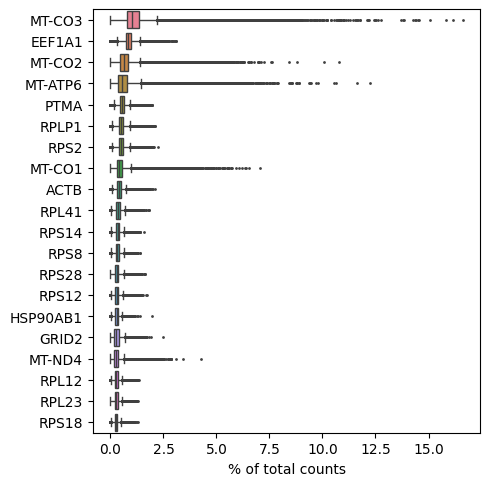

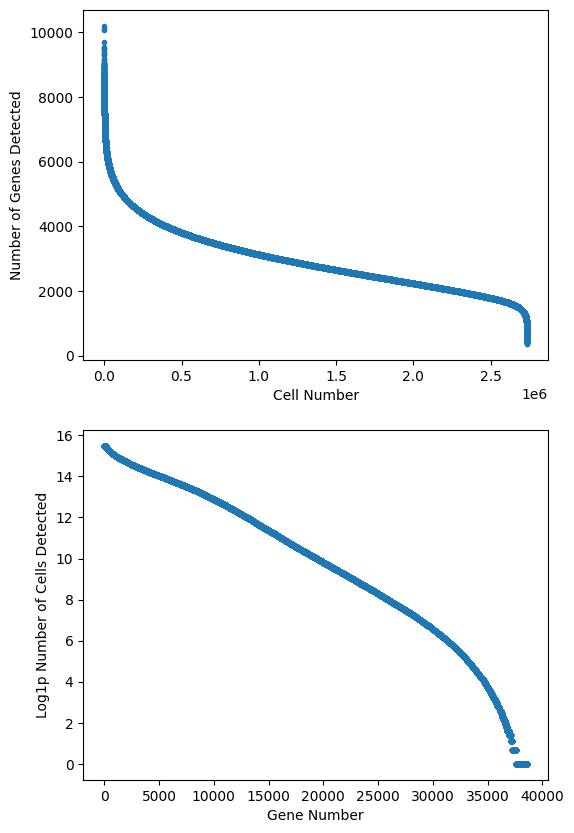

Removing 1039 genes not detected in any cells.


In [ ]:
adata = qc.general_qc(adata)

Now we will filter the cell barcodes. First, we will add a "QC" column to `adata` indicating whether each cell barcode passed QC ("Pass") or not ("Fail"). Then we will filter for the cell barcodes that have "Pass" in the "QC" column.

In [ ]:
adata.obs["QC"] = np.where(adata.obs_names.isin(set(barcodes_qc)), "Pass", "Fail")
adata_filtered = adata[adata.obs["QC"] == "Pass"].copy()

/tmp/ipykernel_2683868/1081968684.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


Add a `run` metadata column to `.obs`:

In [ ]:
adata_filtered.obs["run"] = [label.split('-')[0] for label in adata_filtered.obs.channel]

In [ ]:
adata_filtered

AnnData object with n_obs × n_vars = 2622329 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

Save the QC-passed and metadata-annotated `AnnData` object:

In [ ]:
adata_filtered.write("/home/ranwyl/data_tf_project/adata_QC.h5ad")

Now that we have filtered the cells based on the list from the Mali lab and filtered the genes using a pipeline function, we want to complete steps E and F of the data analysis workflow, which will be performed on the subset of core NTC cells.
-  Step E: Isolate effective single guide RNA (sgRNA)
-  Step F: 1) Isolate sgRNA altering cell state 2) Isolate perturbed cells

Note: functions written in the `Pan_Genome_Analysis.ipynb` file from figshare have been pasted into a file `pan_genome_analysis_functions.py` that is imported as `qc2`

First, we need to take the `AnnData` object that is the output of step D and subset the NTC cells.

In [ ]:
adata = ad.read_h5ad("/home/ranwyl/data_tf_project/adata_QC.h5ad")

In [ ]:
adata

AnnData object with n_obs × n_vars = 2622329 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

In [ ]:
adata[adata.obs.perturbed == "False"]

View of AnnData object with n_obs × n_vars = 38490 × 37567
    obs: 'gRNA', 'n_gRNA', 'n_gRNA_UMIs', 'gene_target', 'celltype', 'perturbation_type', 'n_UMI_counts', 'n_genes', 'perturbed', 'channel', 'QC', 'run'
    var: 'gene_ids', 'feature_types', 'n_UMI_counts', 'n_cells'

The number of NTC cells in `adata` (38490) is higher than the number of core NTC cells in `Pan_Genome_Analysis.ipynb` (37433). Due to this discrepancy, it would be best to run the pipeline myself.

## Cell-by-TF UMAP

After QC, preprocessing, and normalization have been performed, we will now generate the cell-by-TF UMAP. We will subset the genes that are in the list of TFs from Lambert et al (2018). Then we will carry out feature selection, scaling, PCA, and use the PCA "elbow plot" to determine which principal components to use for further analysis.

Experiment: do we subset TFs before feature selection and do feature selection with 1639 genes, then do PCA?
Or do we do feature selection with 2000 genes as normal (TFs should be in here), run PCA, and then subset the TFs?

In [ ]:
# Get list of 1639 Lambert TFs
lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# Subset genes that are TFs
filtered_genes = adata.var.index.isin(tfs)
adata_cell_by_tf = adata[:, filtered_genes]


Now that we have determined the number of PCs to use, we will compute k-nearest neighbors and embed the neighborhood graph in two dimensions for UMAP visualization, perform Leiden clustering, and visualize the UMAP.